# Import

In [1]:
import numpy as np
#from sklearn.model_selection import train_test_split
#import os, sys
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

#import tensorflow as tf
#from tensorflow import keras

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
9
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

from get_dataset import get_training_and_validation

from tensorflow.keras.models import save_model, load_model

# Load Data

In [2]:
batch_size = 16
epochs = 50
IMG_HEIGHT = 256
IMG_WIDTH = 256

# make sure to write own classifier-function in next cell
# if num_classes is greater than 2



In [3]:
# this filter allows all combination with exactly 1 human on it
# artificial masks (photoshop, cg), are not distinguished

# this implicite sets the ['class'] as follows:
#   with_mask >= 1 -> 'mask'
#   with_mask == 0 -> 'no_mask'
#  classifier-attribute can be set to own function for matching data-rows into classes
frame = get_training_and_validation(people_per_img = 1, with_mask=None, no_mask=None, unknown=0,validation_split=0.15 ,test_split=0.1)

train_frame=frame[0]
val_frame=frame[1]
test_frame=frame[2]


print('Filter returned {:d} train images'.format(len(train_frame)))
print(Counter(train_frame['class']))
print('Filter returned {:d} valid images'.format(len(val_frame)))
try:
    print('Filter returned {:d} test images'.format(len(test_frame)))
except:
    print ("Filter returned no test images")
    
num_classes = len(Counter(train_frame['class']))

Filter returned 6867 train images
Counter({'no_mask': 5372, 'mask': 1495})
Filter returned 1373 valid images
Filter returned 915 test images


# Data preparation

In [4]:
def get_data_generator(image_generator, frame, shuffle=True):
    return image_generator.flow_from_dataframe(frame, directory='./', x_col='Path', y_col='class', color_mode="rgb",
                                                 batch_size = batch_size, shuffle=shuffle, target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='categorical')

In [5]:
# generator for all data
image_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=15,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2
                    )
image_generator_test = ImageDataGenerator(rescale=1./255)

In [6]:
train_data_gen = get_data_generator(image_generator, train_frame)

validation_data_gen = get_data_generator(image_generator_test, val_frame)


Found 6858 validated image filenames belonging to 2 classes.
Found 1369 validated image filenames belonging to 2 classes.


C:\Users\Daniel\.conda\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 9 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
C:\Users\Daniel\.conda\envs\tf\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 4 invalid image filename(s) in x_col="Path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [7]:
sample_training_images, _ = next(train_data_gen)

In [10]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img,interpolation='none')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

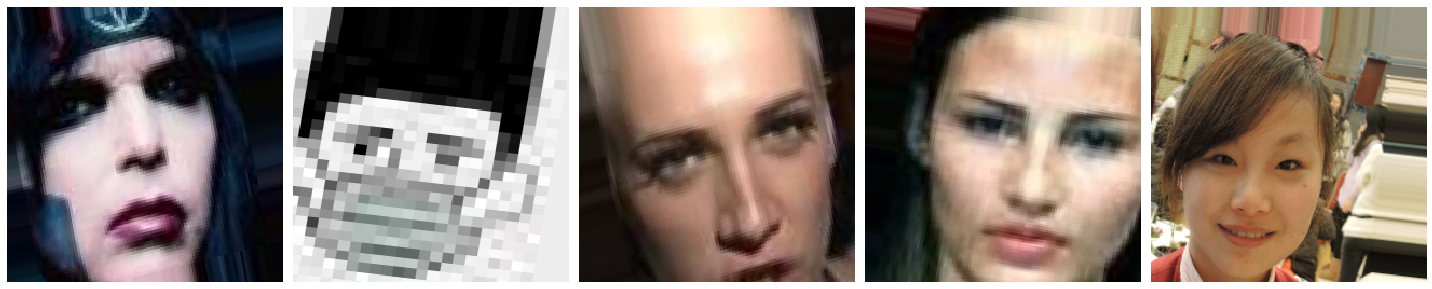

In [9]:
plotImages(sample_training_images[:5])

# Create the model

In [9]:
model = Sequential([
    Conv2D(32, 3, padding='same', strides=2,activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2,activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2,activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#model = Sequential()
#model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
##model.add(Dense(num_classes, activation='softmax'))
#model.add(Dense(512, activation='relu'))
#model.add(Dense(1))
#model.layers[0].trainable = False

In [ ]:
model.compile(optimizer='adam',
              loss=BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']) #TODO: maype 'acc' instead of 'accuracy'

In [ ]:
model.summary()

# Train the model

In [ ]:
epochs_saved=epochs
epochs=5
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch = len(train_data_gen),
    epochs=epochs,
    validation_data=validation_data_gen,
    validation_steps =len(validation_data_gen)
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#RESTORE
epochs=epochs_saved

# Data augmentation

## Flip and Shift

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True,width_shift_range=.15,
                    height_shift_range=.15,)

train_data_gen = get_data_generator(image_gen, train_frame)

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
# Re-use the same custom plotting function defined and used
# above to visualize the training images
plotImages(augmented_images)

## Rotate

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=15)

train_data_gen = get_data_generator(image_gen, train_frame)

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

## Zoom

In [ ]:
# zoom_range from 0 - 1 where 1 = 100%.
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5) # 

In [ ]:
train_data_gen = get_data_generator(image_gen, train_frame)

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [ ]:
plotImages(augmented_images)

## Together

In [11]:
train_data_gen = get_data_generator(image_generator, train_frame)

validation_data_gen = get_data_generator(image_generator_test, val_frame)

Found 6858 validated image filenames belonging to 2 classes.
Found 1369 validated image filenames belonging to 2 classes.


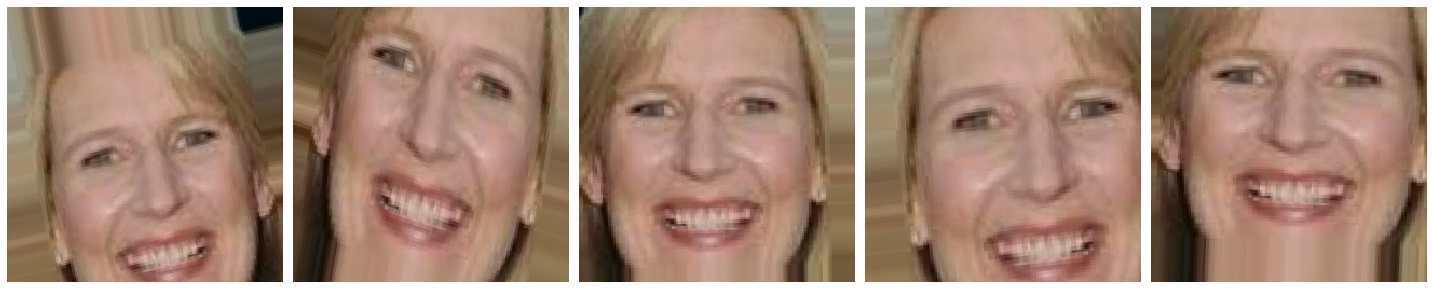

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Model 2 with Dropout

In [13]:
model_new = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, 3, padding='same', strides=2, activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])


In [14]:
model_new.compile( optimizer='rmsprop',
                  loss='binary_crossentropy',#tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

model_new.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)        

# Train2

In [15]:
checkpoint_filepath = './tmp/model_checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1,
                              cooldown=0, mode='auto',min_delta=0.0001, min_lr=0)

In [16]:
#model_new.fit_generator?

In [17]:
history = model_new.fit(
    train_data_gen,
    #steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=validation_data_gen,
    #validation_steps=len(validation_data_gen),
    callbacks=[model_checkpoint_callback,earlyStopping,reduce_lr]
)
#model_new.load_weights(checkpoint_filepath)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 429 steps, validate for 86 steps
Epoch 1/50
429/429 [==============================] - 118s 274ms/step - loss: 0.3067 - accuracy: 0.8934 - val_loss: 0.1509 - val_accuracy: 0.9452
Epoch 2/50
429/429 [==============================] - 116s 269ms/step - loss: 0.2083 - accuracy: 0.9234 - val_loss: 0.1568 - val_accuracy: 0.9394
Epoch 3/50
429/429 [==============================] - 116s 269ms/step - loss: 0.2062 - accuracy: 0.9274 - val_loss: 0.1398 - val_accuracy: 0.9540
Epoch 4/50
429/429 [==============================] - 117s 272ms/step - loss: 0.1781 - accuracy: 0.9398 - val_loss: 0.2574 - val_accuracy: 0.9043
Epoch 5/50
429/429 [==============================] - 114s 266ms/step - loss: 0.1829 - accuracy: 0.9386 - val_loss: 0.1404 - val_accuracy: 0.9518
Epoch 6/50
429/429 [==============================] - 115s 268ms/step - loss: 0.1869 - accuracy: 0.9399 - val_loss: 0.1375 - val_accuracy: 0.9459
Epoch 7/50
429/429 [===========

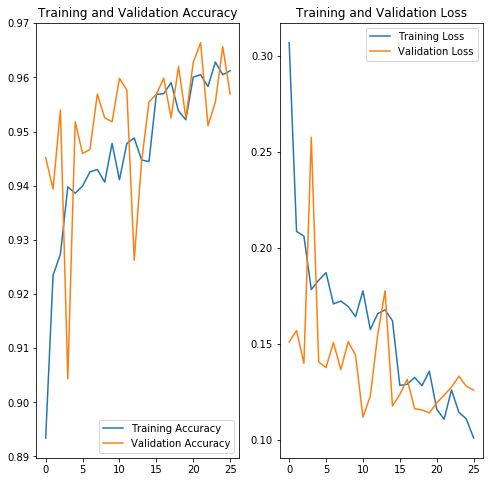

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test

In [19]:
test_data_gen = get_data_generator(image_generator_test, test_frame, shuffle=False)

Found 915 validated image filenames belonging to 2 classes.


In [20]:
#predict=model.predict(test_data_gen)
#predict

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
model_new.load_weights(checkpoint_filepath)
used_model=model_new

total_test=len(test_frame)

Y_pred = used_model.predict(test_data_gen)#, steps=total_test // batch_size+1)
predict_class = np.argmax(Y_pred, axis=1)
predict_class = predict_class.tolist()

ausgabe=0
if ausgabe:
    print('Predict\n',predict_class)
    print('Klassen\n',test_data_gen.classes)
    classes_table=[int(i=='no_mask') for i in test_frame['class'].tolist()]
    print('Klassen Tabelle\n', classes_table)
    print(test_frame['class'].tolist())


print('Confusion Matrix')
print(confusion_matrix(test_data_gen.classes, predict_class))
print('Classification Report')
target_names = ['Mask','NoMask']
print(classification_report(test_data_gen.classes, predict_class, target_names=target_names))

Confusion Matrix
[[183  20]
 [ 13 699]]
Classification Report
              precision    recall  f1-score   support

        Mask       0.93      0.90      0.92       203
      NoMask       0.97      0.98      0.98       712

    accuracy                           0.96       915
   macro avg       0.95      0.94      0.95       915
weighted avg       0.96      0.96      0.96       915



In [25]:
from tensorflow.keras.models import save_model, load_model
used_model.save('saved_model')
#used_model.save('saved_model_test')

INFO:tensorflow:Assets written to: saved_model\assets
